In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%ls -ltrh /Users/laurentperrinet/quantic/grants/Polychronies/RSG-spikepatterns/Data/

total 2267760
-rw-r--r--  1 laurentperrinet  staff   211M Jun 14 10:42 H_Ready-Set_bin1ms_alignedReady.mat
-rw-r--r--  1 laurentperrinet  staff   407M Jun 14 10:55 G_Ready-Set_bin1ms_alignedReady.mat
-rw-r--r--@ 1 laurentperrinet  staff   2.0K Jun 15 12:29 README.md
-rw-r--r--@ 1 laurentperrinet  staff   183M Jun 27 15:52 G_Ready-Set_bin1ms_alignedReady_session=0.npz
-rw-r--r--@ 1 laurentperrinet  staff   212M Jun 27 15:52 G_Ready-Set_bin1ms_alignedReady_session=1.npz
-rw-r--r--@ 1 laurentperrinet  staff    17M Jun 27 15:52 H_Ready-Set_bin1ms_alignedReady_session=0.npz
-rw-r--r--@ 1 laurentperrinet  staff    68M Jun 27 15:52 H_Ready-Set_bin1ms_alignedReady_session=1.npz


In [3]:
i_session = 0
monkey = 'G'
from pathlib import Path
path = Path.home()/'quantic'/'grants'/'polychronies'/'RSG-spikepatterns'/'Data'/f'{monkey}_Ready-Set_bin1ms_alignedReady_session={i_session}.npz'

dictdata = np.load(path)
data, id_neuron, id_short, t_s, t_p = dictdata['data'], dictdata['id_neuron'], dictdata['id_short'], dictdata['t_s'], dictdata['t_p']
data = data.astype(float)
data[data==255] = np.nan
N_time, N_neuron, N_trial = data.shape

N_time, N_neuron, N_trial

(1200, 107, 1498)

### computing the firing rates

In [4]:
t_s_max = int(t_s.max())
DeltaT = 100 # number of time bins on which we average
dt = 20 # temporal distance between points on which we compute the firing rate

timepoints = np.arange(DeltaT, t_s_max+1, dt)
N_timepoints = len(timepoints)
timepoints, N_timepoints

(array([ 100,  120,  140,  160,  180,  200,  220,  240,  260,  280,  300,
         320,  340,  360,  380,  400,  420,  440,  460,  480,  500,  520,
         540,  560,  580,  600,  620,  640,  660,  680,  700,  720,  740,
         760,  780,  800,  820,  840,  860,  880,  900,  920,  940,  960,
         980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180,
        1200]),
 56)

In [5]:
fr = np.empty((N_timepoints, N_neuron, N_trial)) * np.nan
for i_timepoint, timepoint in enumerate(timepoints):
    fr[i_timepoint, :, :] = np.nansum(data[(timepoint-DeltaT):timepoint, :, :], axis=0) / (DeltaT/1000)

In [7]:
# for i_trial in range(N_trial):
#     print(i_trial, torch.isnan(torch.tensor(fr[:, :, i_trial].astype(float))).sum())
#     break
# torch.isnan(torch.tensor(fr.astype(float))).sum(), torch.isnan(torch.tensor(data.astype(float))).sum()

In [8]:
fr.shape

(56, 107, 1498)

In [9]:
from torch.nn.functional import one_hot
one_hot?

Docstring:
one_hot(tensor, num_classes=-1) -> LongTensor

Takes LongTensor with index values of shape ``(*)`` and returns a tensor
of shape ``(*, num_classes)`` that have zeros everywhere except where the
index of last dimension matches the corresponding value of the input tensor,
in which case it will be 1.

See also `One-hot on Wikipedia`_ .

.. _One-hot on Wikipedia:
    https://en.wikipedia.org/wiki/One-hot

Arguments:
    tensor (LongTensor): class values of any shape.
    num_classes (int):  Total number of classes. If set to -1, the number
        of classes will be inferred as one greater than the largest class
        value in the input tensor.

Returns:
    LongTensor that has one more dimension with 1 values at the
    index of last dimension indicated by the input, and 0 everywhere
    else.

Examples:
    >>> F.one_hot(torch.arange(0, 5) % 3)
    tensor([[1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
            [1, 0, 0],
            [0, 1, 0]])
    >>> F.one_ho

In [10]:
labels = np.arange(N_timepoints)[:, None] * np.ones((1, N_trial))
labels.shape

(56, 1498)

In [18]:
ratio_train = 80/100
N_trial_train = int(N_trial*ratio_train)
N_trial_test = N_trial - N_trial_train
idx_trial = np.random.permutation(N_trial)
idx_trial

array([772,   3, 564, ..., 327, 355, 168])

In [42]:
torch.nn.Softmax?

Init signature: torch.nn.Softmax(dim: Optional[int] = None) -> None
Docstring:     
Applies the Softmax function to an n-dimensional input Tensor
rescaling them so that the elements of the n-dimensional output Tensor
lie in the range [0,1] and sum to 1.

Softmax is defined as:

.. math::
    \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}

When the input Tensor is a sparse tensor then the unspecified
values are treated as ``-inf``.

Shape:
    - Input: :math:`(*)` where `*` means, any number of additional
      dimensions
    - Output: :math:`(*)`, same shape as the input

Returns:
    a Tensor of the same dimension and shape as the input with
    values in the range [0, 1]

Args:
    dim (int): A dimension along which Softmax will be computed (so every slice
        along dim will sum to 1).

.. note::
    This module doesn't work directly with NLLLoss,
    which expects the Log to be computed between the Softmax and itself.
    Use `LogSoftmax` instead (it's faster and has

### logistic regression model with NaNs

### inference model

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size


class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, N_input, n_classes, logit0=torch.log(1.*torch.ones(1)), logit_wt=torch.log(0.1*torch.ones(1))):
        super(LogisticRegressionModel, self).__init__() 
        # self.linear = torch.nn.Linear(N, n_classes, bias=bias)

        self.bias = torch.nn.Parameter(logit0 * torch.ones(1, n_classes))
        self.weight = torch.nn.Parameter(logit_wt * torch.ones((N_input, n_classes)))
        # self.nl = torch.nn.Softmax(n_classes)
        self.nl = torch.nn.Sigmoid()

    def forward(self, X_input):
        # X_input.shape = N_batch, N_input
        X_input[torch.isnan(X_input)] = 0.
        return self.nl(X_input @ self.weight +  self.bias)

In [33]:
logistic_model = LogisticRegressionModel(N_neuron, N_timepoints)
i_trial = 3
X = torch.tensor(fr[:, :, i_trial].astype(float))
outputs = logistic_model(X)
X.shape, outputs.shape

(torch.Size([56, 107]), torch.Size([56, 56]))

In [34]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
n_classes=10
amsgrad = True  # gives similar results
amsgrad = False # gives similar results

def fit_data(fr,
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, **kwargs
        ):


    logistic_model = LogisticRegressionModel(N_neuron, N_timepoints)
    # logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for i_trial in idx_trial[range(N_trial_train)]:
            X = torch.tensor(fr[:, :, i_trial].astype(float))
            time_labels = np.arange(N_timepoints)[X.sum(axis=1)>0]
            X = X[X.sum(axis=1)>0, :]
            labels = one_hot(torch.tensor(time_labels), num_classes=N_timepoints)*1.
            # X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    return logistic_model

logistic_model = fit_data(fr, verbose=True)

Iteration: 0 - Loss: 1.78515
Iteration: 16 - Loss: 1.78511
Iteration: 32 - Loss: 1.78507
Iteration: 48 - Loss: 1.78503
Iteration: 64 - Loss: 1.78503
Iteration: 80 - Loss: 1.78498
Iteration: 96 - Loss: 1.78496
Iteration: 112 - Loss: 1.78489
Iteration: 128 - Loss: 1.78478
Iteration: 144 - Loss: 1.78455
Iteration: 160 - Loss: 1.78460
Iteration: 176 - Loss: 1.78462
Iteration: 192 - Loss: 1.78461
Iteration: 208 - Loss: 1.78461
Iteration: 224 - Loss: 1.78461
Iteration: 240 - Loss: 1.78461
Iteration: 256 - Loss: 1.78461
Iteration: 272 - Loss: 1.78461
Iteration: 288 - Loss: 1.78461
Iteration: 304 - Loss: 1.78460
Iteration: 320 - Loss: 1.78460
Iteration: 336 - Loss: 1.78460
Iteration: 352 - Loss: 1.78460
Iteration: 368 - Loss: 1.78460
Iteration: 384 - Loss: 1.78460
Iteration: 400 - Loss: 1.78460
Iteration: 416 - Loss: 1.78460
Iteration: 432 - Loss: 1.78460
Iteration: 448 - Loss: 1.78455
Iteration: 464 - Loss: 1.78440
Iteration: 480 - Loss: 1.78436
Iteration: 496 - Loss: 1.78437
Iteration: 512 -

In [26]:
logistic_model.weight.detach().numpy().shape, logistic_model.weight.detach().numpy().ravel().shape

((107, 56), (5992,))

In [37]:
with torch.no_grad():
    counts = np.zeros((N_timepoints, N_timepoints))
    outputs = np.zeros((N_timepoints, N_timepoints))
    for i_trial in idx_trial[range(N_trial_train, N_trial)]:
        X = torch.tensor(fr[:, :, i_trial].astype(float))
        idx_nonzero = X.sum(axis=1)>0
        counts[idx_nonzero, :] += 1
        time_labels = np.arange(N_timepoints)[idx_nonzero]
        X = X[idx_nonzero, :]
        output = logistic_model(X).numpy()
        outputs[idx_nonzero, :] += output

    outputs = outputs/counts

outputs, outputs.shape

(array([[3.33329519e-163, 3.33329519e-163, 3.33329519e-163, ...,
         3.33329519e-163, 3.33329519e-163, 3.33329519e-163],
        [3.33329519e-223, 3.33329519e-223, 3.33329519e-223, ...,
         3.33329519e-223, 3.33329519e-223, 3.33329519e-223],
        [3.33329519e-233, 3.33329519e-233, 3.33329519e-233, ...,
         3.33329519e-233, 3.33329519e-233, 3.33329519e-233],
        ...,
        [1.75436589e-132, 1.75436589e-132, 1.75436589e-132, ...,
         1.75436589e-132, 1.75436589e-132, 1.75436589e-132],
        [3.50672518e-052, 3.50672518e-052, 3.50672518e-052, ...,
         3.50672518e-052, 3.50672518e-052, 3.50672518e-052],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000]]),
 (56, 56))

In [38]:
torch.tensor(fr[:, :, i_trial].astype(float)).shape

torch.Size([56, 107])

In [ ]:
i_trial = 200
fig, ax = plt.subplots(figsize=(13, 8))
ax.imshow(fr[:, :, i_trial].T, cmap='viridis');

In [16]:
X = torch.tensor(fr[:, :, i_trial].astype(float))
X.shape, X.sum(axis=1)[X.sum(axis=1)>0]

(torch.Size([56, 107]),
 tensor([480., 460., 490., 420., 440., 390., 370., 360., 390., 420., 520., 600.,
         610., 560., 490., 440., 410., 380., 440., 470., 420., 430., 460., 460.,
         480., 550., 530., 510., 500., 460., 430., 460., 480., 480., 470., 440.,
         410., 420., 480., 490., 540., 450., 350., 190., 100.]))

In [ ]:
torch.isnan(torch.tensor(fr[:, :, i_trial].astype(float))).sum()

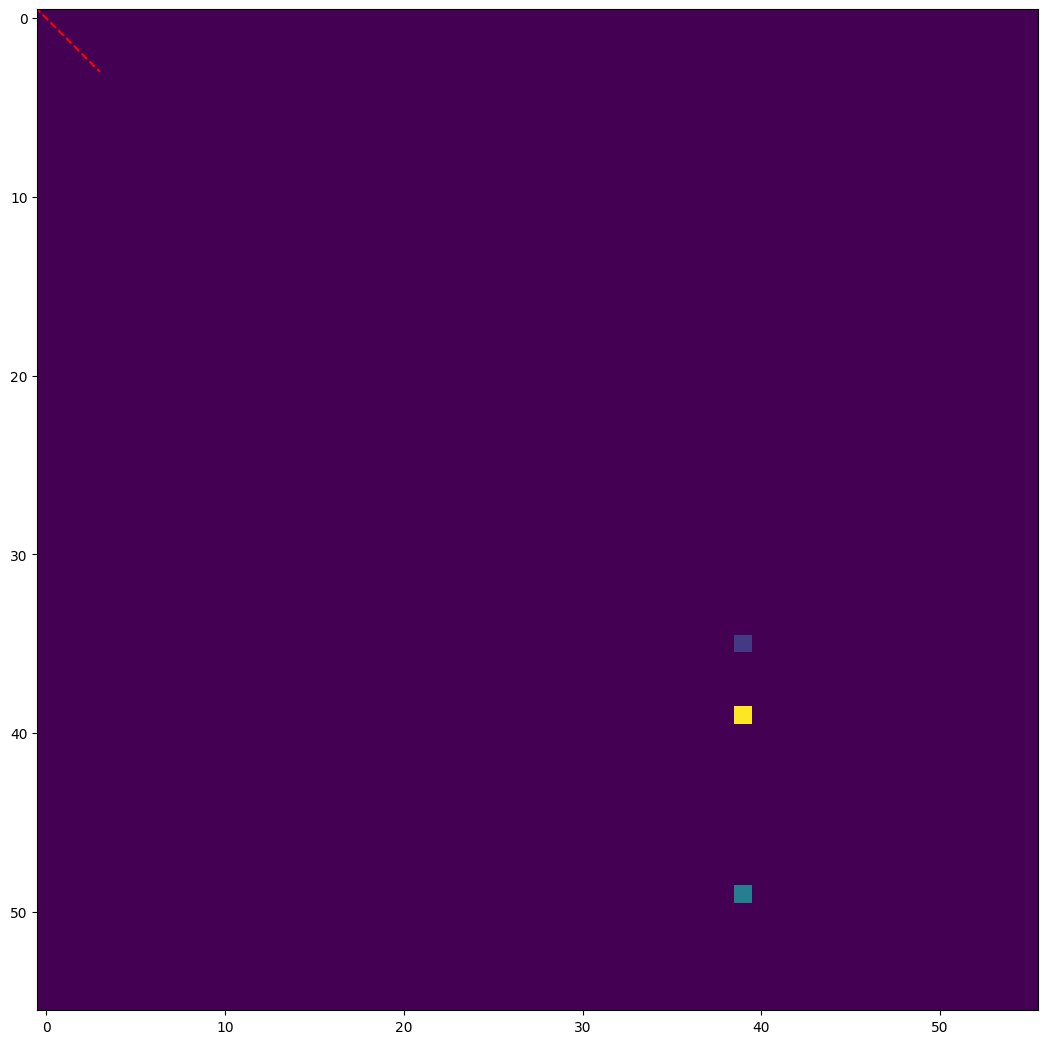

In [40]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.plot([-3, 3], [-3, 3], 'r--')
#ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
# ax.plot(W[-1, :], 'r--')
ax.imshow(outputs, cmap='viridis')

In [41]:
outputs[:5, :5]

array([[3.33329519e-163, 3.33329519e-163, 3.33329519e-163,
        3.33329519e-163, 3.33329519e-163],
       [3.33329519e-223, 3.33329519e-223, 3.33329519e-223,
        3.33329519e-223, 3.33329519e-223],
       [3.33329519e-233, 3.33329519e-233, 3.33329519e-233,
        3.33329519e-233, 3.33329519e-233],
       [3.32948266e-233, 3.32948266e-233, 3.32948266e-233,
        3.32948266e-233, 3.32948266e-233],
       [3.33329519e-193, 3.33329519e-193, 3.33329519e-193,
        3.33329519e-193, 3.33329519e-193]])